## Face Recognition - 11/06/2020


Identification of side facing celebrities with wrong recognization of celebrities that are not a part of the celeb dataset

In [1]:
import cv2

In [2]:
import tensorflow as tf
import pathlib
import numpy as np
import os
import cv2
import keras
from keras.applications import vgg16
from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as pyplot
from sklearn.svm import SVC
from PIL import Image
from skimage import transform
from keras.preprocessing import image
from keras import optimizers
from sklearn.preprocessing import LabelEncoder
from imageio import imread
from skimage.transform import resize
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from mtcnn.mtcnn import MTCNN

%matplotlib inline

Using TensorFlow backend.


In [3]:
data_dir='./cropped/train/'   #path of training directory
data_dir = pathlib.Path(data_dir)

data_dr='./cropped/valid/'    #path of valid_set directory
data_dr = pathlib.Path(data_dr)

image_count = len(list(data_dir.glob('*/*.jpg')))

# generator for training set and valid set. The training data generator employs data augmentation in form of flips and zooms.

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  shear_range=0.2,zoom_range=0.2,
                                                                  rotation_range=90,width_shift_range=0.1,
                                                                  height_shift_range=0.1,horizontal_flip=True)

In [4]:
BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH = 160
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

# name of classes
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['Anne_Hathaway', 'Ayushmann_Khurrana', 'Brad_Pitt', 'Irrfan_Khan',
       'Jen_Aniston', 'Jen_Lawrence', 'Johnny_Depp', 'Pankaj_Tripathi',
       'Robert_DowneyJr', 'Will_Smith'], dtype='<U18')

In [5]:
#iterable form of generators

train_data_gen = train_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

valid_data_gen = image_generator.flow_from_directory(directory=str(data_dr),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 1295 images belonging to 10 classes.
Found 358 images belonging to 10 classes.


In [6]:
images,labels=next(train_data_gen)
x_test,y_test=next(valid_data_gen)

In [7]:
input_shape=(160,160,3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)


model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
              

In [8]:
history = model.fit(train_data_gen, steps_per_epoch=10, epochs=20,
                              validation_data=valid_data_gen, validation_steps=10, 
                              verbose=1)        

In [9]:
model.save('./facenet-model_20200508.h5')

In [10]:
model=load_model('./facenet-model_20200508.h5')

In [11]:
image_dir_basepath = './images/train/'
names = CLASS_NAMES
image_size = 160

In [23]:
test_dirpath = os.path.join('./images/side_pose')
test_filepaths = [os.path.join(test_dirpath, f) for f in os.listdir(test_dirpath)]

In [32]:
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (160,160, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

# draw each face separately
def draw_faces(filename, result_list):
    # load the image
    data = pyplot.imread(filename)
    fig, axes = pyplot.subplots(1,1, figsize=(15, 15))
    axes.imshow(data)
    h,w,c=data.shape
    # plot each face as a subplot
    for i in range(len(result_list)):
        # get coordinates 
        x1, y1, width, height = result_list[i]['box']
        x2, y2 = x1 + width, y1 + height
        np_image = data[y1:y2,x1:x2]
        np_image = np.array(np_image).astype('float32')/255
        np_image = transform.resize(np_image, (160, 160, 3))
        img = np.expand_dims(np_image, axis=0)
        img_class=model.predict(img) 
        prob=np.max(img_class)
        cls=np.argmax(img_class)
        #print(prob)
        if(prob>0.9):
            rect = Rectangle((x1,y1),width,height,linewidth=1,edgecolor='r',facecolor='none')
            pyplot.text(x1, y1-10,names[cls%10], fontsize=10,color='r')
            pred.append(names[cls%10])
            axes.add_patch(rect)
        else:
            rect = Rectangle((x1,y1),width,height,linewidth=1,edgecolor='r',facecolor='none')
            pyplot.text(x1, y1-10,'Unidentified Celeb', fontsize=10,color='r')
            pred.append('Unidentified Celeb')
            axes.add_patch(rect)
    # show the plot
    pyplot.show()

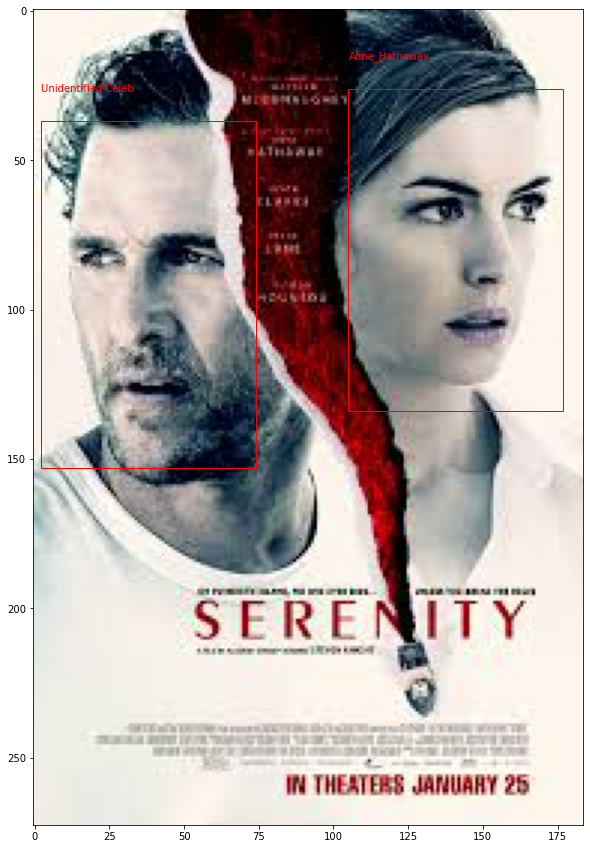

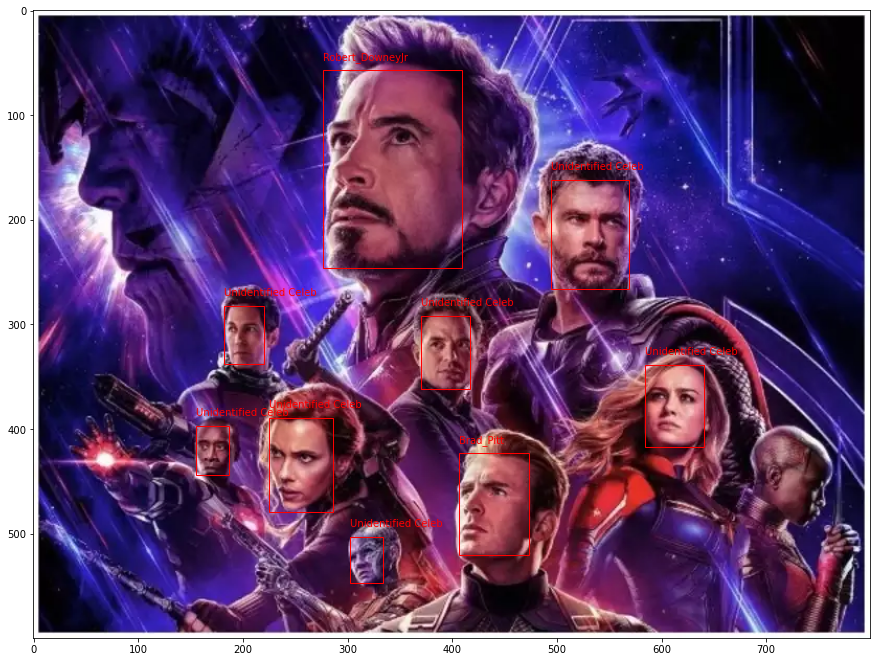

In [25]:
pred=[]
for i in range(len(test_filepaths)): 
    pixels = pyplot.imread(test_filepaths[i])
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    faces = detector.detect_faces(pixels)
    # display faces on the original image
    draw_faces(test_filepaths[i], faces)

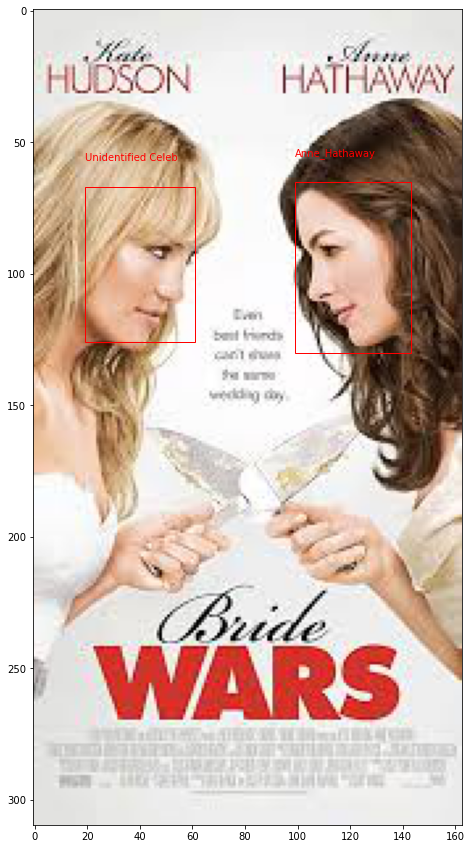

In [33]:
pixels = pyplot.imread('./images/ah5.jpg')
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_faces('./images/ah5.jpg', faces)

The model used here is vgg16 which is used for feature extraction of the images. The model is able to detect side posing faces. Along with it it is incorrectly recognizing some faces that are not a part of the celeb dataset